# Hw2  - Part 2 

|Name     |Campus Email| ID  |
|---------|--------------------------------|----------|
|Oren Elmakis| oren.elmakis@campus.technion.ac.il|311265516|
|Alon spinner| alonspinner@campus.technion.ac.il| 305184335|

# Import

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2

import torch
from torch import nn

import torchvision as tv
from torchvision import transforms
from torchvision.datasets import ImageFolder

from PIL import Image

import glob

import seaborn as sns

from sklearn.svm import LinearSVC

#from torch.utils.cpp_extension import CUDA_HOME

# Q1
Load VGG16

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
VGG16model=tv.models.vgg16(pretrained=True, progress=True).to(device)
VGG16model.eval();

# Q2
Load bird images and display them

In [3]:
def ImageImport(img_dir):
    images = []
    data_path = os.path.join(img_dir,'*.jpg')
    for ImgName in glob.glob(data_path):
        ImgFile = Image.open(ImgName)
        images.append(ImgFile)
    return images

def PlotImages(images):
    fig,axes = plt.subplots(1,len(images),figsize = (16,2.5))
    for idx,image in enumerate(images):
        axes[idx].imshow(image)
        axes[idx].set_title("Picture Shape: {}".format(np.shape(image)))

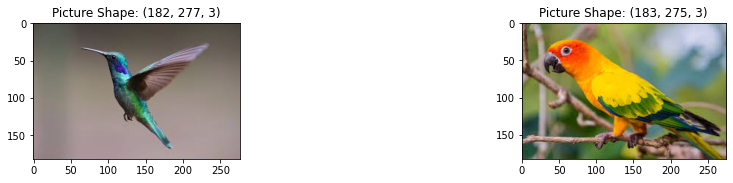

In [4]:
BirdImages=ImageImport('./birds')
PlotImages(BirdImages)

# Q3
Preprocess the images to fit VGG16's architecture

pictures need to be at least 224x224 and sorted in minibatches of (3xHxW)

also, they need to be in range [0,1] and normalized using mean=[0.485,0.456,0.406] and std=[0.229,0.224,0.225]

In [5]:
#check values of pictures to see their scale
HummingBird_np=np.array(BirdImages[0].getdata())
print("value range is {}-{}".format(HummingBird_np.min(),(HummingBird_np.max())))

value range is 0-255


In [6]:
def fit2VGG16(images,device):
    preprocess = transforms.Compose([  
        transforms.Resize((224)),
        transforms.ToTensor(),   #also converts imaget to 0-1 instead of 0-255. tested and verified by **
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    transformed_images=[]
    for im in images:
        t_im = preprocess(im).unsqueeze(0).to(device) #unsqueeze makes the size [1,3,W,H]
        transformed_images.append(t_im)
    return transformed_images #cant use tensor.stack() because images may not be of the same size!!
    
    #**https://discuss.pytorch.org/t/why-does-transforms-totensor-convert-the-range-to-0-1/26095

In [7]:
def PlotImagesVGG16(images):
    fig,axes = plt.subplots(1,len(images),figsize = (16,2.5))
    for idx,image in enumerate(images):
        axes[idx].imshow(image.squeeze().permute(1, 2, 0))
        axes[idx].set_title("Picture Shape: {}".format(np.shape(image)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


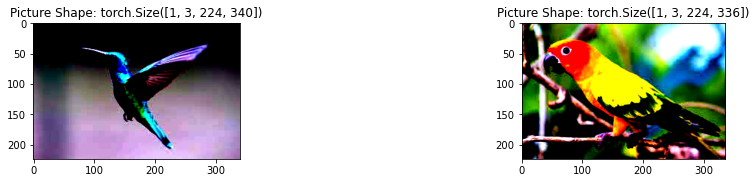

In [8]:
BirdImages_VGG16=fit2VGG16(BirdImages,device)
PlotImagesVGG16(BirdImages_VGG16)

# Q4
Feed the images (forward pass) to the model. What are the outputs?

In [35]:
#load imagenet class names and map id2key

#from https://github.com/pytorch/vision/issues/484
#https://github.com/Cadene/pretrained-models.pytorch/blob/master/examples/imagenet_logits.py

# Load Imagenet Synsets
with open('./my_data/imagenet_synsets.txt', 'r') as f:
    synsets = f.readlines()
# len(synsets)==1001
 # sysnets[0] == background

synsets = [x.strip() for x in synsets]
splits = [line.split(' ') for line in synsets]
key_to_classname = {spl[0]:' '.join(spl[1:]) for spl in splits}

with open('./my_data/imagenet_classes.txt', 'r') as f:
    class_id_to_key = f.readlines()

class_id_to_key = [x.strip() for x in class_id_to_key]

In [10]:
# Make predictions
output = VGG16model(BirdImages_VGG16[0]) # size(1, 1000)
_,index = output.data[0].max(0)
class_id = index.item()
class_key = class_id_to_key[class_id]
classname = key_to_classname[class_key]
print(classname)

hummingbird


In [11]:
def predict(images, model, class_id_to_key, key_to_classname):
    predictions=[]
    for image in images:
        _, index = model(image).data[0].max(0)
        class_id = index.item()
        class_key = class_id_to_key[class_id]
        class_name = key_to_classname[class_key]
        predictions.append((class_id,class_name))
    return predictions

In [12]:
def plot_predictions(images,predictions,device):
    #images before preprocess!
    fig,axes = plt.subplots(1,len(images),figsize = (16,2.5))
    for idx,image in enumerate(images):
        axes[idx].imshow(image)
        axes[idx].set_title("class {}\n{}".format(predictions[idx][0],predictions[idx][1]))
        axes[idx].axis('off')

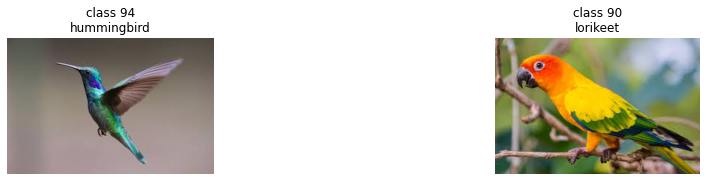

In [13]:
predictions=predict(BirdImages_VGG16, VGG16model, class_id_to_key, key_to_classname)
plot_predictions(BirdImages,predictions,device)

# Q5
Find an image of a bird/cat/dog online and feed it to the network. what are the outputs?

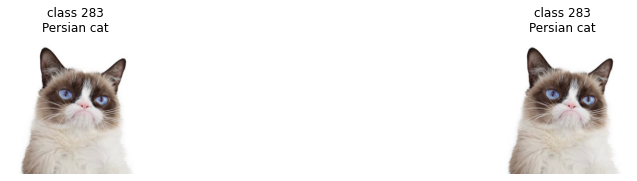

In [14]:
#my functions only work with lists of 2 or more... we group two grumpy cats togther

GrumpyCatImgName="./my_data/GrumpyCat.jpg"
GrumpyCat = Image.open(GrumpyCatImgName)
images_GrumpyCat = (GrumpyCat,GrumpyCat)

#convert to VGG16 format
images_GrumpyCat_VGG16=fit2VGG16(images_GrumpyCat,device)

#make predictions and see what's what
predictions=predict(images_GrumpyCat_VGG16, VGG16model, class_id_to_key, key_to_classname)
plot_predictions(images_GrumpyCat,predictions,device)

# Q6
apply transformations to the image from Q5 using cv2
<br>
**geomtreic**:rotation/scaling/translation/warping
<br>
**color transformation**: thresholding, different color space, hue, saturation, brightness, contrast...
<br>
**filter**: anything u want

pass through VGG16

In [15]:
#turn GrumpyCat to numpy so we can apply cv2 transforatmion
GrumpyCat_np=np.array(GrumpyCat) #also turns to RGB

In [16]:
#gaussian blur  
kernel_size=(11,11)
sigma=10
GrumpyCat_np_Blur=cv2.GaussianBlur(GrumpyCat_np,kernel_size,sigma)
GrumpyCat_PIL_Blur=Image.fromarray(GrumpyCat_np_Blur)

#Canny edge detector
GrumpyCat_np_Canny=cv2.Canny(GrumpyCat_np_Blur, 20, 80)
GrumpyCat_np_Canny_RGB = cv2.cvtColor(GrumpyCat_np_Canny,cv2.COLOR_GRAY2RGB)
GrumpyCat_PIL_Canny=Image.fromarray(GrumpyCat_np_Canny_RGB)

#45 degree rotation
[rows,cols] = GrumpyCat_np.shape[0:2]
M45 = cv2.getRotationMatrix2D((cols/2,rows/2),45,1) #rotate 45 degrees, 1 scale factor
GrumpyCat_np_Rot45 = cv2.warpAffine(GrumpyCat_np,M45,(cols,rows))
GrumpyCat_PIL_Rot45=Image.fromarray(GrumpyCat_np_Rot45)

#180 degree rotation
[rows,cols] = GrumpyCat_np.shape[0:2]
M180 = cv2.getRotationMatrix2D((cols/2,rows/2),180,1) #rotate 180 degrees, 1 scale factor
GrumpyCat_np_Rot180 = cv2.warpAffine(GrumpyCat_np,M180,(cols,rows))
GrumpyCat_PIL_Rot180=Image.fromarray(GrumpyCat_np_Rot180)

# Q7
feed the transformed images to the network and see what's what

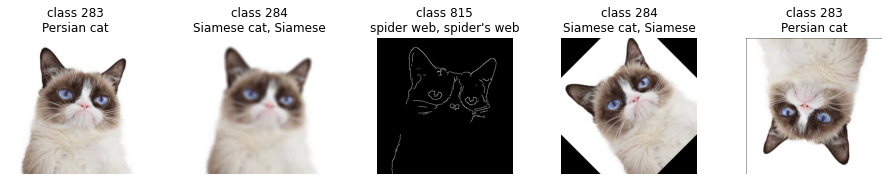

In [17]:
#pass through VGG16
images_GrumpyCat_1=(GrumpyCat,GrumpyCat_PIL_Blur,GrumpyCat_PIL_Canny,GrumpyCat_PIL_Rot45,GrumpyCat_PIL_Rot180)

#convert to VGG16 format
images_GrumpyCat_VGG16_1=fit2VGG16(images_GrumpyCat_1,device)

#make predictions and see what's what
predictions_1=predict(images_GrumpyCat_VGG16_1, VGG16model, class_id_to_key, key_to_classname)
plot_predictions(images_GrumpyCat_1,predictions_1,device)

# Another run of Q6,7

In [18]:
#greener transformation
GreenFactor=1.9
GrumpyCat_np_Green=np.copy(GrumpyCat_np)
GrumpyCat_np_Green[:,:,1]=np.clip(GrumpyCat_np[:,:,1]*GreenFactor,0,255)
GrumpyCat_PIL_Green=Image.fromarray(GrumpyCat_np_Green)

#LAB transformation
GrumpyCat_np_LAB=cv2.cvtColor(GrumpyCat_np,cv2.COLOR_RGB2LAB)
GrumpyCat_PIL_LAB=Image.fromarray(GrumpyCat_np_LAB)

#threshold 50
[_,GrumpyCat_np_Threshold50] = cv2.threshold(GrumpyCat_np,50,255,cv2.THRESH_BINARY)
GrumpyCat_PIL_Threshold50=Image.fromarray(GrumpyCat_np_Threshold50)

#threshold 127
[_,GrumpyCat_np_Threshold127] = cv2.threshold(GrumpyCat_np,127,255,cv2.THRESH_BINARY)
GrumpyCat_PIL_Threshold127=Image.fromarray(GrumpyCat_np_Threshold127)

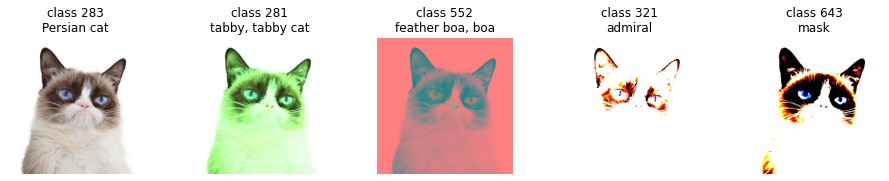

In [19]:
#pass through VGG16
images_GrumpyCat_2=(GrumpyCat,GrumpyCat_PIL_Green,GrumpyCat_PIL_LAB,GrumpyCat_PIL_Threshold50,GrumpyCat_PIL_Threshold127)

#convert to VGG16 format
images_GrumpyCat_VGG16_2=fit2VGG16(images_GrumpyCat_2,device)

#make predictions and see what's what
predictions_2=predict(images_GrumpyCat_VGG16_2, VGG16model, class_id_to_key, key_to_classname)
plot_predictions(images_GrumpyCat_2,predictions_2,device)

# Q8
For the ﬁrst 3 ﬁlters in the ﬁrst layer of VGG16, plot the ﬁlters, and then plot their response (their output) for the image from section 5 and the 3 images from section 6 (total of 4 input images)

In [20]:
#functions to visualize the kernels from ee046746_tut_02_03_appndx_visualizing_cnn_filters.ipynb

def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0] * t.shape[2]
    ncols = t.shape[1] * t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))
#     fig, ax = plt.subplots(nrows=nrows, ncols=ncols)  
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)
    
    
def plot_filters_single_channel(t):
    
    # kernels depth * number of kernels
    nplots = t.shape[0] * t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots // ncols
    # convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    # looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    
    
def plot_filters_multi_channel(t):
    
    # get the number of kernals
    num_kernels = t.shape[0]    
    
    # define number of columns for subplots
    num_cols = 12
    # rows = num of kernels
    num_rows = num_kernels
    
    # set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    # looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        # for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        # standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
#     plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    
    
def plot_weights(model, layer_num, single_channel=True, collated=False):
    # extracting the model features at the particular layer number
    layer = model.features[layer_num]
  
    # checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
        # getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data

        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
    else:
        print("Can only visualize layers which are convolutional")

In [21]:
#lets view VGG16:
print(VGG16model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
#some testing to see what's what:
layer_num=0
layer = VGG16model.features[layer_num]
print('layer number: {}'.format(layer_num))
print(layer)

weight_tensor = VGG16model.features[layer_num].weight.data
print('layer wight tensor shape:')
print(weight_tensor.shape)

layer number: 0
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer wight tensor shape:
torch.Size([64, 3, 3, 3])


First 3 filters of layer0 in VGG16:


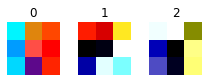

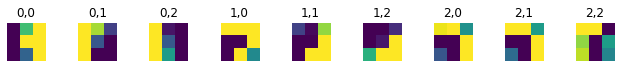

In [23]:
print('First 3 filters of layer0 in VGG16:')
plot_filters_multi_channel(weight_tensor[:3])
plot_filters_single_channel(weight_tensor[:3])

In [24]:
def filter_outputs(images,model,layer_to_visualize,FilterNumber):
    modulelist = list(model.features.modules())
    FilterOutputs=[]
    for image in images:
        for count, layer in enumerate(modulelist[1:]):
            image = layer(image)
            if count == layer_to_visualize: 
                output = image.data.squeeze().cpu().numpy()
                FilterOutputs.append(output[FilterNumber,:,:])
    
    fig,axes = plt.subplots(1,len(images),figsize = (16,2.5))
    for idx,FilterOutput in enumerate(FilterOutputs):
        axes[idx].imshow(FilterOutput)
        axes[idx].axis('off')

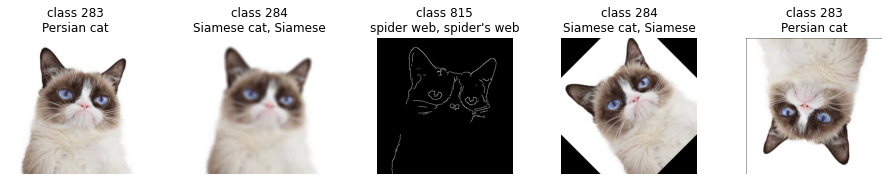

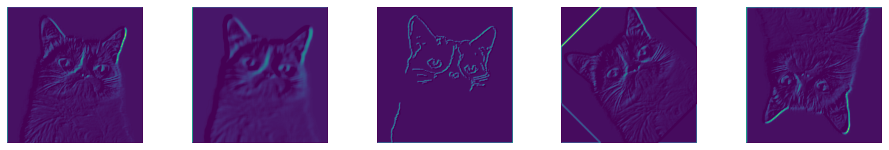

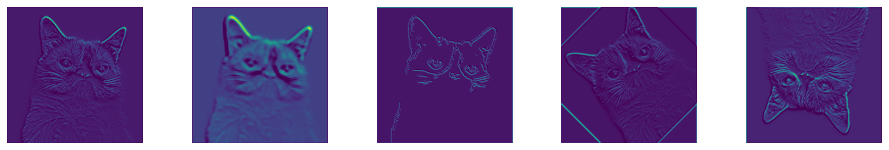

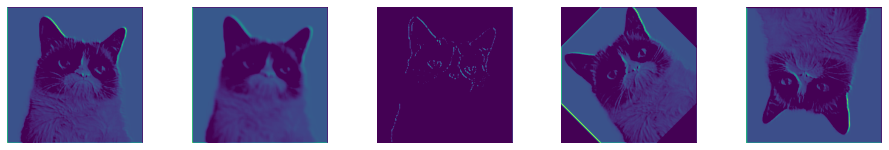

In [25]:
plot_predictions(images_GrumpyCat_1,predictions_1,device)
filter_outputs(images_GrumpyCat_VGG16_1,VGG16model,layer_to_visualize=0,FilterNumber=1)
filter_outputs(images_GrumpyCat_VGG16_1,VGG16model,layer_to_visualize=0,FilterNumber=2)
filter_outputs(images_GrumpyCat_VGG16_1,VGG16model,layer_to_visualize=0,FilterNumber=3)

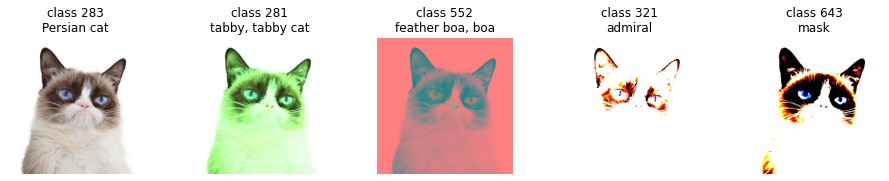

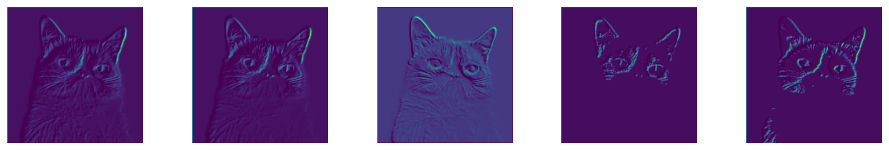

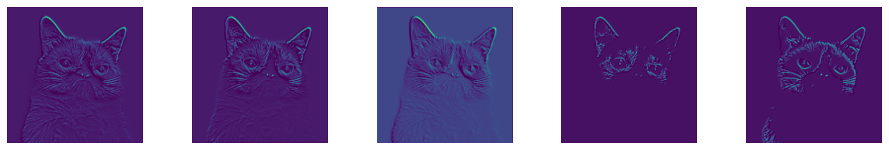

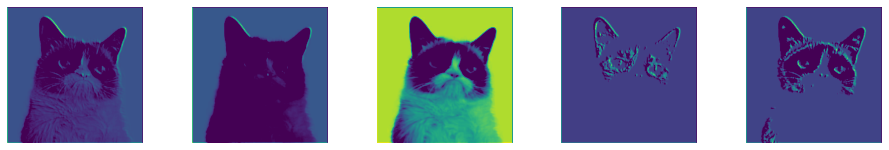

In [26]:
plot_predictions(images_GrumpyCat_2,predictions_2,device)
filter_outputs(images_GrumpyCat_VGG16_2,VGG16model,layer_to_visualize=0,FilterNumber=1)
filter_outputs(images_GrumpyCat_VGG16_2,VGG16model,layer_to_visualize=0,FilterNumber=2)
filter_outputs(images_GrumpyCat_VGG16_2,VGG16model,layer_to_visualize=0,FilterNumber=3)

# Q9
For each image in the ./dogs and ./cats folders, extract and save their feature vectors (create a numpy array or a torch tensor that contains the features for all samples) from a fully-connected layer (such as FC7) of the VGG16 model (you need to write a function that does the feed forward manually until the desired layer, there is an example in ee046746_appndx_visualizing_cnn_filters.ipynb). Which layer did you pick? What is the size of the feature space?

In [27]:
def PlotImages_DogsCats(images):
    fig,axes = plt.subplots(1,10,figsize = (16,2.5))
    for idx,image in enumerate(images):
        axes[idx].imshow(image)
        axes[idx].set_title((np.shape(image)))
        axes[idx].axis('off')

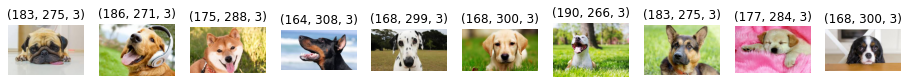

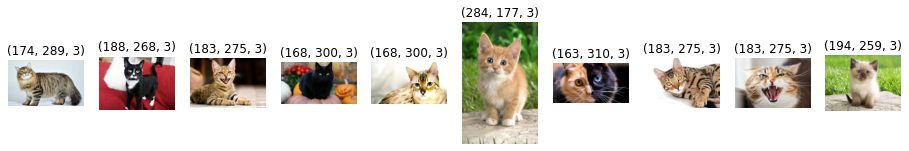

In [28]:
DogImages=ImageImport('./dogs')
PlotImages_DogsCats(DogImages)
DogImages_VGG16=fit2VGG16(DogImages,device)

CatImages=ImageImport('./cats')
PlotImages_DogsCats(CatImages)
CatImages_VGG16=fit2VGG16(CatImages,device)

In [29]:
def extract_features_for_classifier(images,model,FClayer4features):
    modulelist_FC = list(model.classifier.modules())
    Features=[]
     
    for image in images:
        #run on all CNN
        image=model.features(image) 
        
        #preprocess for FC
        AvgPool2D=nn.AdaptiveAvgPool2d(output_size=(7, 7))
        image=AvgPool2D(image)
        image=image.view(image.size(0),-1)     
        
        #Run on FC until reaching FClayer4features
        for count, layer in enumerate(modulelist_FC[1:]):
            image = layer(image)
            if count == FClayer4features:
                output = image.data.squeeze().cpu().numpy()
                Features.append(output)
                break
    return Features

In [30]:
DogFeatures=extract_features_for_classifier(DogImages_VGG16,VGG16model,FClayer4features=6)
CatFeatures=extract_features_for_classifier(CatImages_VGG16,VGG16model,FClayer4features=6)
print("Feature space shape per image of a cat/dog")
print(DogFeatures[0].shape)

Feature space shape per image of a cat/dog
(1000,)


# Q10
Build a Support Vector Machine (SVM) classiﬁer (sklearn.svm.LinearSVC) to classify cats and dogs based on the features you extracted. Use the 20 images as train set, and choose 4 images (2 dogs, 2 cats) from the internet as test sets. You can choose a different classifer than SVM from the scikit-learn library, no need to explain how it works (but report the name of the algorithm you used). What are the results?

In [31]:
#fit SVM classifier

#dog = 0, cat = 1
DogsCatsFeatures=DogFeatures+CatFeatures
Features_list = np.asarray(DogsCatsFeatures) #features 
y = np.concatenate((np.zeros(10),np.ones(10))) #ground truth vector

SVMclf = LinearSVC()
SVMclf.fit(Features_list,y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

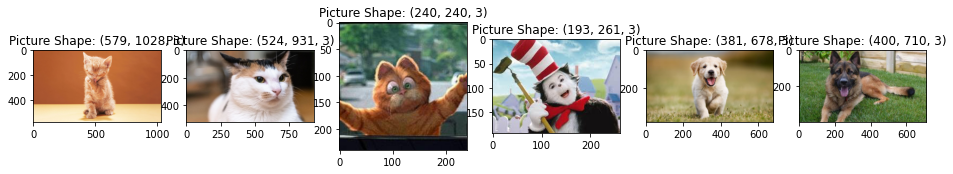

In [32]:
#Test Images:
Q10TestImages=ImageImport('./my_data/Q10TestImages')
PlotImages(Q10TestImages)

In [33]:
def plot_predictions_dogscats(images,predictions):
    #images before preprocess!
    fig,axes = plt.subplots(1,len(images),figsize = (16,2.5))
    classes=['Dog','Cat']
    for idx,image in enumerate(images):
        axes[idx].imshow(image)
        axes[idx].set_title("class {}\n{}".format(predictions[idx],classes[int(predictions[idx])]))
        axes[idx].axis('off')

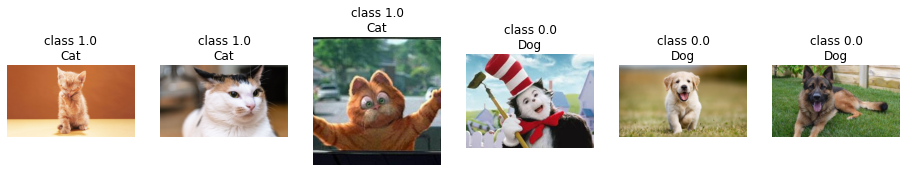

In [34]:
#predict Q10TestImages via SVM 
Q10TestImages_VGG16=fit2VGG16(Q10TestImages,device)
Q10TestImages_Features=extract_features_for_classifier(Q10TestImages_VGG16,VGG16model,FClayer4features=6)
predictions=SVMclf.predict(Q10TestImages_Features)
plot_predictions_dogscats(Q10TestImages,predictions)